In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%matplotlib inline
%reload_ext autoreload
%autoreload 2


import itertools as it
import multiprocessing as mp

from typing import List, Tuple, Generator, Iterator

import numpy as np
SEED = 0x1234
np.random.seed(SEED)
np.set_printoptions(suppress=True)

import scipy as sp
from scipy import stats, optimize

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format =  'png'

import seaborn as sns

import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('precision', 3)

import sklearn as skl

import ipywidgets as widgets
from ipywidgets import interact

from pprint import pprint

import joblib

In [4]:
# Helpers
def latexify(fig_width=None, fig_height=None, columns=1, scale=1.0):
    from math import sqrt
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}, how many columns it covers
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])
    
    #width  = 3.487
    #height = width / 1.618

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5) - 1.0) / 2.0    # Aesthetic ratio
        fig_height = fig_width * golden_mean # height in inches
        
        
    fig_height *= scale
    fig_width *= scale

    MAX_HEIGHT_INCHES = 16.0 * scale
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {
        # Use LaTex to write all text
        'text.usetex': True,
        'font.family': 'serif',
        #'font.serif': 'Times',
        # Use 10pt font in plots, to match 10pt font in document
        #'axes.labelsize': 10,
        #'font.size': 10,
        # Make the legend/label fonts a little smaller
        #'legend.fontsize': 8,
        #'xtick.labelsize': 8,
        #'ytick.labelsize': 8,
        
        'figure.autolayout': True,
        'figure.figsize': [fig_width, fig_height],
        
        'savefig.format': 'pdf',
        'savefig.bbox': 'tight',
        
        'pdf.fonttype': 42,
        
        #'legend.framealpha': 0.2,
        
        'grid.color': '0.9',
        'grid.linestyle': ':',
    }
    
    mpl.style.use('default')
    mpl.style.use(['seaborn-notebook', 'seaborn-whitegrid', 'seaborn-ticks'])
    mpl.rcParams.update(params)
    

def set_size(width, fraction=1):
    from math import sqrt
    # SRC: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    
    # 252.0pt is IEEEtrans columnwidth (\showthe\columnwidth)
    
    
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    elif width == 'pnas':
        width_pt = 246.09686
    else:
        width_pt = width
    
    fig_width_pt = width_pt * fraction
    inches_per_pt = 1.0 / 72.27
    golden_ratio = (sqrt(5) - 1.0) / 2.0
    
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_width_in * golden_ratio
    fig_dim = (fig_width_in, fig_height_in)
    return fig_dim


def format_axes(ax, SPINE_COLOR='gray', despine=False):
    
    if despine:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
        

    for spine in ['left', 'bottom', 'top', 'right']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    #ax.xaxis.set_ticks_position('bottom')
    #ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax


def ensure_dir(path: str):
    from pathlib import Path
    _path = Path(path)
    _path.parent.mkdir(parents=True, exist_ok=True)
    return path


latexify(columns=2)

memory = joblib.Memory(location='.cache', verbose=0)

In [17]:
from datasets.trace1_Rutgers.transform import get_traces, dtypes
from datasets.trace1_Rutgers import NOISE_SOURCES

coords = Tuple[float, float]

def get_distance(points: Tuple[coords,coords]) -> float:
    assert len(points) == 2, 'Require exactly 2 points to calculate distance'
    (x1, y1), (x2, y2) = points
    d = np.sqrt(np.power(x2 - x1, 2) + np.power(y2 - y1, 2))
    return d

def dbm2mw(value: float) -> float:
    return 0.001 * np.power(10, value / 10.)

def mw2dbm(value: float) -> float:
    return 10. * np.log10(value / 0.001)

TX_POWER = 10.0 # dBm
RSSI_BASE = -95.0 # dBm; not sure for this one. Most of the Atheros' have -95
FREQ = 2450.0 # MHz


def rssi2rss(rssi):
    return rssi + RSSI_BASE

@memory.cache
def get_rutgers_datapoints() -> pd.DataFrame:
    def name2coords(name: str) -> Tuple[float, float]:
        part = name[len('node'):] # extract only numeric part 'node3-2' -> '3-2'
        coords = [float(i) for i in part.split('-')]
        return tuple(coords)
    
    df = []
    
    for trace in get_traces():
        src = trace['src'].values[0]
        dst = trace['dst'].values[0]
        noise = trace['noise'].values[0]

        # Fix names
        src = name2coords(src)
        dst = name2coords(dst)

        trace.src = trace.src.apply(name2coords)
        trace.dst = trace.dst.apply(name2coords)

        # Split column, row
        trace['srcRow'], trace['srcCol'] = src
        trace['dstRow'], trace['dstCol'] = dst

        # Preserve sequence number
        trace['seq'] = trace.index

        trace['rss'] = trace.rssi + RSSI_BASE

        trace['d'] = trace[['src', 'dst']].apply(get_distance, axis=1)

        df.append(trace)
        
    df = pd.concat(df, ignore_index=True)
    return df
    
get_rutgers_datapoints().sample(n=10, random_state=SEED)

,rssi,received,error,seq,noise,src,dst,srcRow,srcCol,dstRow,dstCol,rss,d
125577,0,False,False,177,-10,"(5.0, 6.0)","(1.0, 4.0)",5.0,6.0,1.0,4.0,-95.0,4.472
156939,0,False,False,39,-10,"(6.0, 7.0)","(8.0, 1.0)",6.0,7.0,8.0,1.0,-95.0,6.325
657373,0,False,False,73,-20,"(5.0, 6.0)","(6.0, 1.0)",5.0,6.0,6.0,1.0,-95.0,5.099
858876,0,False,False,276,-5,"(5.0, 6.0)","(1.0, 6.0)",5.0,6.0,1.0,6.0,-95.0,4.000
175641,15,True,False,141,-10,"(8.0, 3.0)","(7.0, 6.0)",8.0,3.0,7.0,6.0,-80.0,3.162
1051788,8,True,False,288,-15,"(1.0, 2.0)","(1.0, 6.0)",1.0,2.0,1.0,6.0,-87.0,4.000
1075047,0,False,False,147,-15,"(8.0, 1.0)","(5.0, 8.0)",8.0,1.0,5.0,8.0,-95.0,7.616
608505,0,False,False,105,-20,"(7.0, 4.0)","(1.0, 8.0)",7.0,4.0,1.0,8.0,-95.0,7.211
133045,10,True,False,145,-10,"(5.0, 8.0)","(6.0, 3.0)",5.0,8.0,6.0,3.0,-85.0,5.099
319869,0,False,False,69,0,"(1.0, 8.0)","(7.0, 4.0)",1.0,8.0,7.0,4.0,-95.0,7.211


In [12]:
@memory.cache
def produce_dataset(Wprr:int=10, Wh:int=10, predict_ahead:int=1) -> pd.DataFrame:
    
    assert isinstance(Wprr, int)
    assert isinstance(Wh, int)
    assert isinstance(predict_ahead, int)
    
    def name2coords(name: str) -> Tuple[float, float]:
        part = name[len('node'):] # extract only numeric part 'node3-2' -> '3-2'
        coords = [float(i) for i in part.split('-')]
        return tuple(coords)
    
    df = []
    
    for trace in get_traces():
        src = trace['src'].values[0]
        dst = trace['dst'].values[0]
        noise = trace['noise'].values[0]

        # Fix names
        src = name2coords(src)
        dst = name2coords(dst)

        trace.src = trace.src.apply(name2coords)
        trace.dst = trace.dst.apply(name2coords)

        # Split column, row
        trace['srcRow'], trace['srcCol'] = src
        trace['dstRow'], trace['dstCol'] = dst

        # Preserve sequence number
        trace['seq'] = trace.index

        trace['rss'] = trace.rssi + RSSI_BASE

        trace['d'] = trace[['src', 'dst']].apply(get_distance, axis=1)
        
        trace['meanRSSI'] = trace.rssi.rolling(window=Wh).mean()
        trace['medianRSSI'] = trace.rssi.rolling(window=Wh).median()
        trace['stdRSSI'] = trace.rssi.rolling(window=Wh).std()
        
        trace['PRR'] = trace.received.rolling(window=Wprr).sum() / Wprr
        
        for i in range(1, predict_ahead+1):
            trace[f'PRR+{i}'] = trace.PRR.shift(-Wprr * predict_ahead)

        df.append(trace)
        
    df = pd.concat(df, ignore_index=True)
    return df
    
produce_dataset().head(20)

,rssi,received,error,seq,noise,src,dst,srcRow,srcCol,dstRow,dstCol,rss,d,meanRSSI,medianRSSI,stdRSSI,PRR,PRR+1
0,14,True,False,0,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-81.0,5.099,NaN,NaN,NaN,NaN,1.0
1,11,True,False,1,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-84.0,5.099,NaN,NaN,NaN,NaN,1.0
2,7,True,False,2,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-88.0,5.099,NaN,NaN,NaN,NaN,1.0
3,6,True,False,3,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-89.0,5.099,NaN,NaN,NaN,NaN,1.0
4,5,True,False,4,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-90.0,5.099,NaN,NaN,NaN,NaN,1.0
5,8,True,False,5,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-87.0,5.099,NaN,NaN,NaN,NaN,1.0
6,4,True,False,6,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-91.0,5.099,NaN,NaN,NaN,NaN,1.0
7,8,True,False,7,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-87.0,5.099,NaN,NaN,NaN,NaN,1.0
8,6,True,False,8,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-89.0,5.099,NaN,NaN,NaN,NaN,1.0
9,6,True,False,9,-10,"(4.0, 3.0)","(3.0, 8.0)",4.0,3.0,3.0,8.0,-89.0,5.099,7.5,6.5,2.991,1.0,1.0


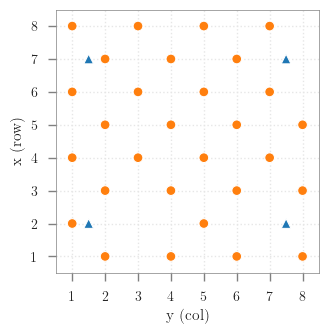

In [16]:
def plot_map():
    dataset = get_rutgers_datapoints()
    
    noise_generator_positions = pd.DataFrame(data=list(NOISE_SOURCES), columns=['row', 'col'])
    noise_generator_positions['type'] = 'interference'

    known_nodes = dataset.src.append(dataset.dst, ignore_index=True).unique().tolist()
    known_nodes = pd.DataFrame(data=known_nodes, columns=['row', 'col'])
    known_nodes['type'] = 'node'

    positions = pd.concat([noise_generator_positions, known_nodes], ignore_index=True).reset_index(drop=True)

    latexify(fig_height=8) # This one is a bit special
    f, ax = plt.subplots()

    sns.scatterplot(data=positions, x='col', y='row', style='type', hue='type', markers=['^','o'], ax=ax, legend=None)
    ax.set_aspect('equal', 'box')

    ax.set_xlabel(None)
    ax.set_ylabel(None)

    ax.invert_yaxis()

    ax.set_xticks(np.arange(1, 9, 1))
    ax.set_yticks(np.arange(1, 9, 1))
    
    ax.set_xlim([.5, 8.5])
    ax.set_ylim([.5, 8.5])
    
    ax.set_ylabel('x (row)')
    ax.set_xlabel('y (col)')

    #ax.grid(which='major', color='0.9', linestyle=':')
    ax.grid()

    #sns.despine(f, ax)
    format_axes(ax)

    #f.savefig(ensure_dir(f'{FIGURE_OUTPUT}/rutgers-map.pdf'))
    plt.show(f)
    plt.close(f)
    
    return f, ax
    
plot_map();